In [22]:
# Basic python packages
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import matplotlib.pyplot as plt
import glob
import splitfolders

# Packages related to images
from PIL import Image
import PIL


In [13]:
def clean_data(path):
    df = pd.read_csv(path)
    df = df[df['Creator'] != ''] 
    df = df[df['Creator'] != 'anoniem']
    df = df[df['Creator'] != 'onbekend']
    df = df[df['Creator'].notna()]
    df = df.replace('Koning, Cornelis (?-1671)', 'Koning, Cornelis')
    return df

def preprocess_data(df, num_artworks = 10):
    df = df.groupby("Creator").filter(lambda x: len(x) >= num_artworks)
    return df

df = clean_data('../Data/Rijksmuseum/xml_files.csv')
rijksdata = preprocess_data(df, 500)

In [14]:
rijksdata

,Identifier,Creator,Title,Date,Type
100,RP-T-1905-158(R),"Fokke, Simon","Jonge edelman, naar links in gebogen houding",1710 - 1779,tekening
101,RP-T-1905-158(V),"Fokke, Simon",Zittende man,ca. 1710 - ca. 1779,tekening
2275,SK-C-5,Rembrandt Harmensz. van Rijn,Officieren en andere schutters van wijk II in ...,1642 - 1642,schilderij
2276,SK-C-6,Rembrandt Harmensz. van Rijn,De Staalmeesters: het college van staalmeester...,1662 - 1662,schilderij
2277,SK-A-3340,Rembrandt Harmensz. van Rijn,Borstbeeld van een man in oosterse kleding (),1635 - 1635,schilderij
...,...,...,...,...,...
111901,RP-P-OB-85.858,"Vinkeles, Reinier",Plunderen van huizen van patriotten te Devente...,1787 - 1795,prent
111902,RP-P-OB-85.859,"Vinkeles, Reinier",Plunderen van huizen van patriotten te Devente...,1787 - 1795,prent
111903,RP-P-OB-85.860,"Vinkeles, Reinier","Vlucht van patriotten uit Franeker, 1787 ()",1787 - 1795,prent
111947,BK-17474,Meissener Porzellan Manufaktur,Servies,ca. 1750 - ca. 1760,servies


In [15]:
#Paths to different folders/files
img_list = glob.glob("../Data/Rijksmuseum/jpg2/*.jpg")
image_dir = "../Data/Rijksmuseum/jpg2/"
split_image_dir = "../Data/Rijksmuseum/jpg2_split_500/"

n_labels = len(rijksdata.groupby('Creator').count())

In [16]:
n_labels

21

In [17]:
# labels = pd.read_csv(labels_file)
labels = rijksdata[['Identifier', 'Creator']]
labels

,Identifier,Creator
100,RP-T-1905-158(R),"Fokke, Simon"
101,RP-T-1905-158(V),"Fokke, Simon"
2275,SK-C-5,Rembrandt Harmensz. van Rijn
2276,SK-C-6,Rembrandt Harmensz. van Rijn
2277,SK-A-3340,Rembrandt Harmensz. van Rijn
...,...,...
111901,RP-P-OB-85.858,"Vinkeles, Reinier"
111902,RP-P-OB-85.859,"Vinkeles, Reinier"
111903,RP-P-OB-85.860,"Vinkeles, Reinier"
111947,BK-17474,Meissener Porzellan Manufaktur


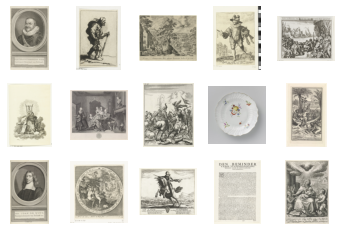

In [18]:
def plot_random_images(img_names, n_x=2, n_y=2, seed=0):
    """
    Plots random images from de data set in a n_x by n_y grid

    :image_names: List with the names of all images
    :n_x: Height of the grid
    :n_x: Width of the grid
    :seed: Seed for the random sample
    :return: nothing
    """ 
    f, axs = plt.subplots(n_x, n_y)
    sample = img_names.sample(n_x * n_y, random_state=seed)
    c = 0
    for x in range(n_x):
        for y in range(n_y):
            img_loc = [item for item in img_list if sample.iloc[c] in item][0]
            img = plt.imread(img_loc)
            axs[x, y].imshow(img)
            axs[x, y].axis('off')
            c += 1

plot_random_images(labels["Identifier"], 3, 5)

In [19]:
labels['Creator'].iloc[0]

'Fokke, Simon'

# Reformat data for learning
To be able to load the data with a generator. We must split the training and validation data and place them into a folder based on their label.

In [20]:
def generate_label_folders(image_path, image_names, image_labels, destination_path):
    """
    Splits a single folder with images into multiple folders where images are placed based on their labels.

    :image_path: path to the folder with the images
    :image_names: A numpy array with the names of all images
    :image_labels: A numpy array with the labels of all images
    :destination_path: Path of the folder where the images are placed into
    :return: Nothing
    """ 
    for i in range(len(image_names)):
        if i % 522 == 0:
            print(str(round(i/len(image_names)*100, 3)) + '%')
            
        # Check if the directory exists. Else, make one
        isExist = os.path.exists(os.path.join(destination_path, str(image_labels.iloc[i])))
        if not isExist:
            os.makedirs(os.path.join(destination_path, str(image_labels.iloc[i])))
            
        # Copy the image
        img_loc = [item for item in img_list if image_names.iloc[i] in item][0]
        img = Image.open(img_loc)
        img.save(destination_path + "/" + str(image_labels.iloc[i]) + "/" + image_names.iloc[i] + ".jpg")
        

generate_label_folders(image_dir, labels["Identifier"], labels["Creator"], split_image_dir)

0.0%
2.746%
5.493%
8.239%
10.985%
13.732%
16.478%
19.224%
21.971%
24.717%
27.464%
30.21%
32.956%
35.703%
38.449%
41.195%
43.942%
46.688%
49.434%
52.181%
54.927%
57.673%
60.42%
63.166%
65.913%
68.659%
71.405%
74.152%
76.898%
79.644%
82.391%
85.137%
87.883%
90.63%
93.376%
96.122%
98.869%


In [23]:
splitfolders.ratio(split_image_dir, output="output", seed=1337, ratio=(.7, .1, .2)) 

Copying files: 19007 files [00:52, 358.79 files/s]
